In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import timm
import albumentations as A
from tqdm import tqdm
import shutil
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
!mkdir -p /content/train/Benign
!mkdir -p /content/train/Malignant
 #Unzip data
!unzip -q zipped-train-Benign.zip -d /content/train/Benign
!unzip -q zipped-train-Malignant.zip -d /content/train/Malignant

unzip:  cannot find or open zipped-train-Benign.zip, zipped-train-Benign.zip.zip or zipped-train-Benign.zip.ZIP.
unzip:  cannot find or open zipped-train-Malignant.zip, zipped-train-Malignant.zip.zip or zipped-train-Malignant.zip.ZIP.


In [4]:
def prepare_data():
    """Prepare and augment the dataset"""

    #  Create target folders
    os.makedirs('/content/train/Benign', exist_ok=True)
    os.makedirs('/content/train/Malignant', exist_ok=True)

In [5]:
# Verify data
def verify_data(Benign_imgs, Malignant_imgs):
    print(f"✅ Benign images found: {len(Benign_imgs)}")
    print(f"✅ Malignant images found: {len(Malignant_imgs)}")

    return Benign_imgs, Malignant_imgs

def augment_data():
    """Augment the dataset using Albumentations"""
    pass

In [6]:
# Create output folders
aug_dir = '/content/train_augmented' # Define aug_dir
os.makedirs(f'{aug_dir}/Benign', exist_ok=True)
os.makedirs(f'{aug_dir}/Malignant', exist_ok=True)

In [7]:
# Augmentation pipeline
augment = A.Compose([
    A.Rotate(limit=15, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.Resize(224, 224)
])

def augment_images(class_type):
    image_paths = glob.glob(f'{input_dir}/{class_type}/*.jpg')
    for path in tqdm(image_paths, desc=f"Augmenting {class_type}"):
        try:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            base_name = os.path.splitext(os.path.basename(path))[0]

            for i in range(3):  # Create 3 augmented versions
                aug_img = augment(image=img)['image']
                aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
                save_path = f'{aug_dir}/{class_type}/{base_name}_aug{i}.jpg'
                cv2.imwrite(save_path, aug_img)

        except Exception as e:
            print(f"⚠️ Error processing {path}: {e}")

In [8]:
input_dir = '/content/train'
# Run for both classes
augment_images('Benign')
augment_images('Malignant')

def merge_datasets():
    """Merge original and augmented datasets"""

    final_train_dir = '/content/final_train_data'
    os.makedirs(f'{final_train_dir}/Benign', exist_ok=True)
    os.makedirs(f'{final_train_dir}/Malignant', exist_ok=True)
    return final_train_dir

Augmenting Malignant: 100%|██████████| 700/700 [00:03<00:00, 206.70it/s]


In [9]:
final_train_dir = '/content/final_train_data'
merge_datasets()
# Copy original data
for path in glob.glob('/content/train/Benign/*.jpg'):
    shutil.copy(path, f'{final_train_dir}/Benign/')

for path in glob.glob('/content/train/Malignant/*.jpg'):
    shutil.copy(path, f'{final_train_dir}/Malignant/')

In [10]:
# Copy augmented data
for path in glob.glob('/content/train_augmented/Benign/*.jpg'):
    shutil.copy(path, f'{final_train_dir}/Benign/')

for path in glob.glob('/content/train_augmented/Malignant/*.jpg'):
    shutil.copy(path, f'{final_train_dir}/Malignant/')

In [11]:
# Count final images
Benign_images = glob.glob('/content/final_train_data/Benign/*.jpg')
Malignant_images = glob.glob('/content/final_train_data/Malignant/*.jpg')

print(f"✅ Total Benign (healthy) Images: {len(Benign_images)}")
print(f"✅ Total Malignant (sick) Images: {len(Malignant_images)}")
print(f"🟢 Total Training Images: {len(Benign_images) + len(Malignant_images)}")

def verify_augment_merge():
    Benign_imgs = glob.glob('/content/train/Benign/*.jpg')
    Malignant_imgs = glob.glob('/content/train/Malignant/*.jpg')
    Benign_imgs, Malignant_imgs = verify_data(Benign_imgs, Malignant_imgs)

    augment_data()
    augment_images('Benign')
    augment_images('Malignant')

    merge_datasets()

    Benign_images = glob.glob('/content/final_train_data/Benign/*.jpg')
    Malignant_images = glob.glob('/content/final_train_data/Malignant/*.jpg')

    print(f"✅ Total Benign (healthy) Images: {len(Benign_images)}")
    print(f"✅ Total Malignant (sick) Images: {len(Malignant_images)}")
    print(f"🟢 Total Training Images: {len(Benign_images) + len(Malignant_images)}")

    return final_train_dir

✅ Total Benign (healthy) Images: 2800
✅ Total Malignant (sick) Images: 2800
🟢 Total Training Images: 5600


In [12]:
#DATA LOADERS
def create_dataloaders(data_dir, batch_size=16):
    """Create train, validation, and test dataloaders"""

    # Transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Load full dataset
    full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

    # Calculate split sizes
    dataset_size = len(full_dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, full_dataset.classes

In [13]:
# Call the function with the data directory
# Replace '/path/to/your/data' with the actual path to your data
train_loader, val_loader, test_loader, classes = create_dataloaders(final_train_dir)

print(f"Train samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# The return statement is inside the function, so it's not needed here.
# return train_loader, val_loader, test_loader, full_dataset.classes

Train samples: 3919
Validation samples: 840
Test samples: 841


In [14]:
# MODEL DEFINITION
def create_model(num_classes=2):
    """Create and initialize the ViT model"""

    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    model = model.to(device)

    return model

In [15]:
# ==================== TRAINING ====================
def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=1e-4):
    """Train the model"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Calculate epoch statistics
        epoch_loss = running_loss / total
        epoch_acc = correct / total * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation
        val_acc = evaluate(model, val_loader)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  - Loss: {epoch_loss:.4f}")
        print(f"  - Train Accuracy: {epoch_acc:.2f}%")
        print(f"  - Val Accuracy: {val_acc:.2f}%")
        print("-" * 50)

    return train_losses, train_accuracies, val_accuracies

def evaluate(model, dataloader):
    """Evaluate model performance"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [16]:
# ==================== EVALUATION ====================
def comprehensive_evaluation(model, test_loader, class_names):
    """Comprehensive evaluation with metrics"""

    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    test_acc = 100 * sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)

    print(f"✅ Test Accuracy: {test_acc:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    return all_preds, all_labels

In [17]:
# ==================== VISUALIZATION ====================
def plot_training_history(train_losses, train_accuracies, val_accuracies):
    """Plot training history"""

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, marker='o', label='Train', color='blue')
    plt.plot(val_accuracies, marker='o', label='Validation', color='red')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_pixel_distribution(data_dir):
    """Plot pixel intensity distribution"""

    classes = ['Benign', 'Malignant']

    for cls in classes:
        img_paths = glob.glob(f'{data_dir}/{cls}/*.jpg')

        all_r, all_g, all_b = [], [], []

        for path in img_paths[:200]:  # Sample for speed
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
            all_r.extend(r.flatten())
            all_g.extend(g.flatten())
            all_b.extend(b.flatten())

        plt.figure(figsize=(10, 4))
        plt.hist(all_r, bins=256, color='red', alpha=0.5, label='R channel')
        plt.hist(all_g, bins=256, color='green', alpha=0.5, label='G channel')
        plt.hist(all_b, bins=256, color='blue', alpha=0.5, label='B channel')
        plt.title(f'Pixel Intensity Distribution - {cls}')
        plt.xlabel('Pixel value (0-255)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

Step 1: Preparing data...

Step 2: Augmenting data...

Step 3: Merging datasets...

Step 4: Creating dataloaders...

Step 5: Creating model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Step 6: Training model...
Epoch 1/5
  - Loss: 0.7001
  - Train Accuracy: 58.54%
  - Val Accuracy: 66.19%
--------------------------------------------------
Epoch 2/5
  - Loss: 0.5791
  - Train Accuracy: 69.18%
  - Val Accuracy: 78.33%
--------------------------------------------------
Epoch 3/5
  - Loss: 0.4466
  - Train Accuracy: 79.28%
  - Val Accuracy: 86.55%
--------------------------------------------------
Epoch 4/5
  - Loss: 0.3136
  - Train Accuracy: 86.94%
  - Val Accuracy: 87.98%
--------------------------------------------------
Epoch 5/5
  - Loss: 0.2399
  - Train Accuracy: 89.90%
  - Val Accuracy: 85.36%
--------------------------------------------------

Step 7: Plotting training history...


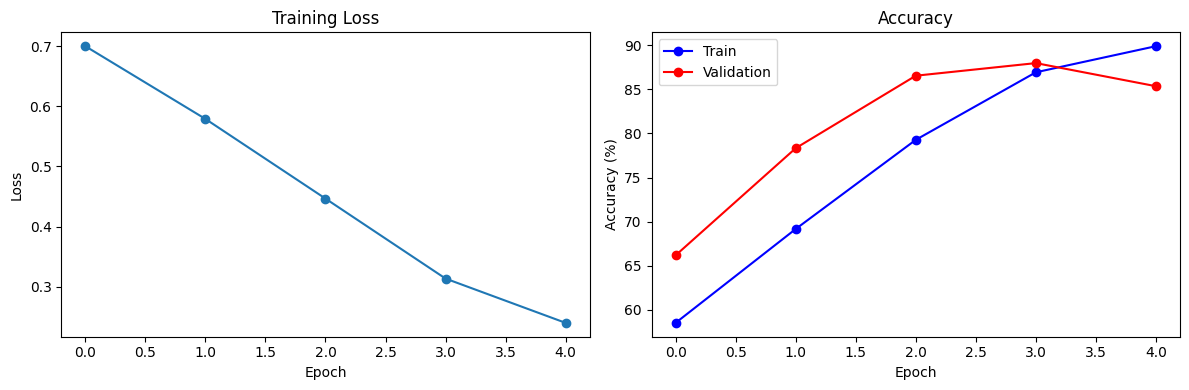


Step 8: Comprehensive evaluation...
✅ Test Accuracy: 87.75%

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.76      0.86       411
   Malignant       0.81      0.99      0.89       430

    accuracy                           0.88       841
   macro avg       0.90      0.87      0.88       841
weighted avg       0.90      0.88      0.88       841

Confusion Matrix:
[[313  98]
 [  5 425]]

Step 9: Plotting pixel distribution...


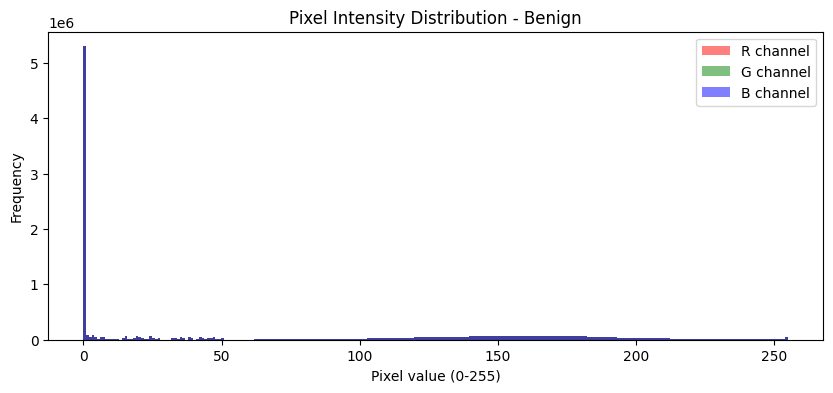

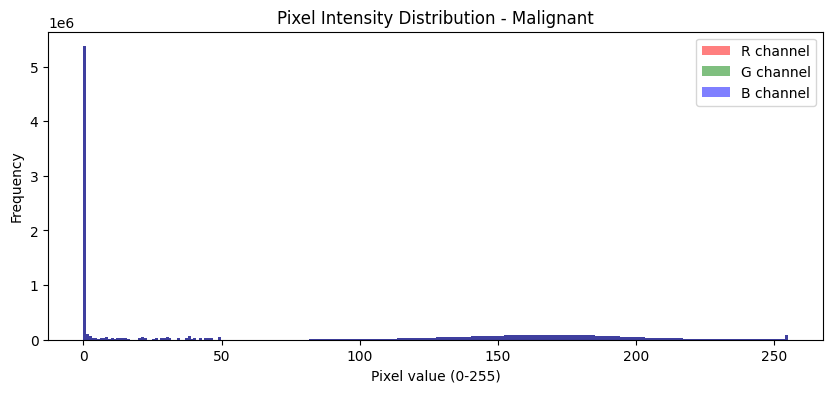


Step 10: Saving model...
✅ Model saved as 'vit_breast_model.pth'


In [18]:
# ==================== MAIN EXECUTION ====================
if __name__ == "__main__":
    # 1. Prepare data
    print("Step 1: Preparing data...")
    prepare_data()

    # 2. Augment data
    print("\nStep 2: Augmenting data...")
    augment_data()

    # 3. Merge datasets
    print("\nStep 3: Merging datasets...")
    final_train_dir = merge_datasets()

    # 4. Create dataloaders
    print("\nStep 4: Creating dataloaders...")
    train_loader, val_loader, test_loader, class_names = create_dataloaders(final_train_dir)

    # 5. Create model
    print("\nStep 5: Creating model...")
    model = create_model(num_classes=2)

    # 6. Train model
    print("\nStep 6: Training model...")
    train_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, num_epochs=5
    )

    # 7. Plot training history
    print("\nStep 7: Plotting training history...")
    plot_training_history(train_losses, train_accuracies, val_accuracies)

    # 8. Comprehensive evaluation
    print("\nStep 8: Comprehensive evaluation...")
    all_preds, all_labels = comprehensive_evaluation(model, test_loader, class_names)

    # 9. Plot pixel distribution
    print("\nStep 9: Plotting pixel distribution...")
    plot_pixel_distribution(final_train_dir)

    # 10. Save model
    print("\nStep 10: Saving model...")
    torch.save(model.state_dict(), 'vit_breast_model.pth')
    print("✅ Model saved as 'vit_breast_model.pth'")

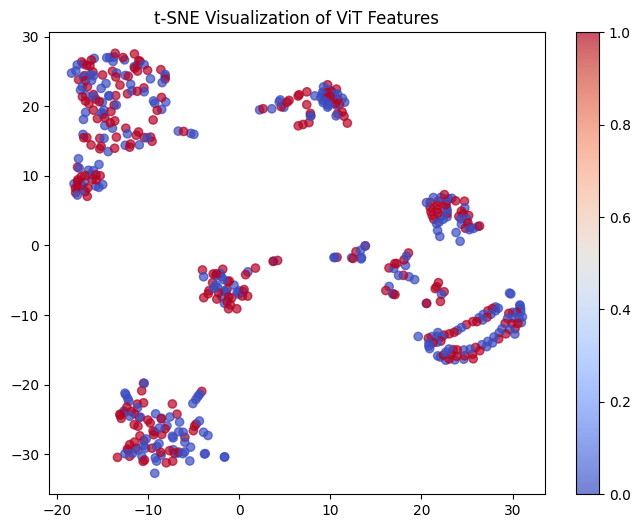

In [19]:
from sklearn.manifold import TSNE

# Extract features from the model
all_features = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader: # Using val_loader as a sample
        images, labels = images.to(device), labels.to(device)
        # Get features before the classification head
        features = model.forward_features(images)
        all_features.extend(features.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert list of features/labels to numpy arrays
X = np.vstack(all_features)   # Stack features into a single array
y = np.hstack(all_labels)     # Stack labels into a single array

# Take a sample to speed up TSNE computation (e.g., first 500 samples)
X_sample = X[:500]
y_sample = y[:500]

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

# Fit TSNE on the sampled features
X_2d = tsne.fit_transform(X_sample)

# Plot the 2D embedding
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_sample, cmap="coolwarm", alpha=0.7)
plt.colorbar()
plt.title("t-SNE Visualization of ViT Features")
plt.show()

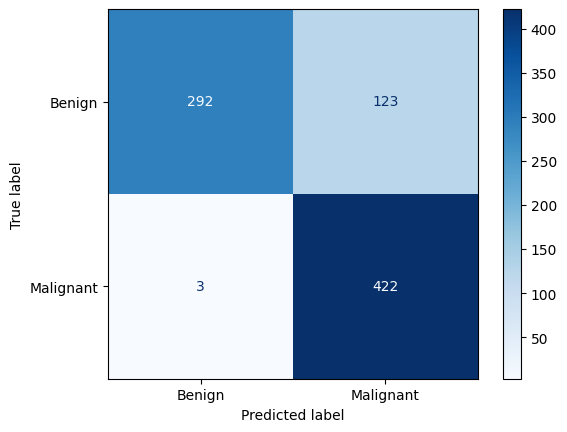

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [21]:
!pip install vit-pytorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 6.5 MB/s eta 0:00:00


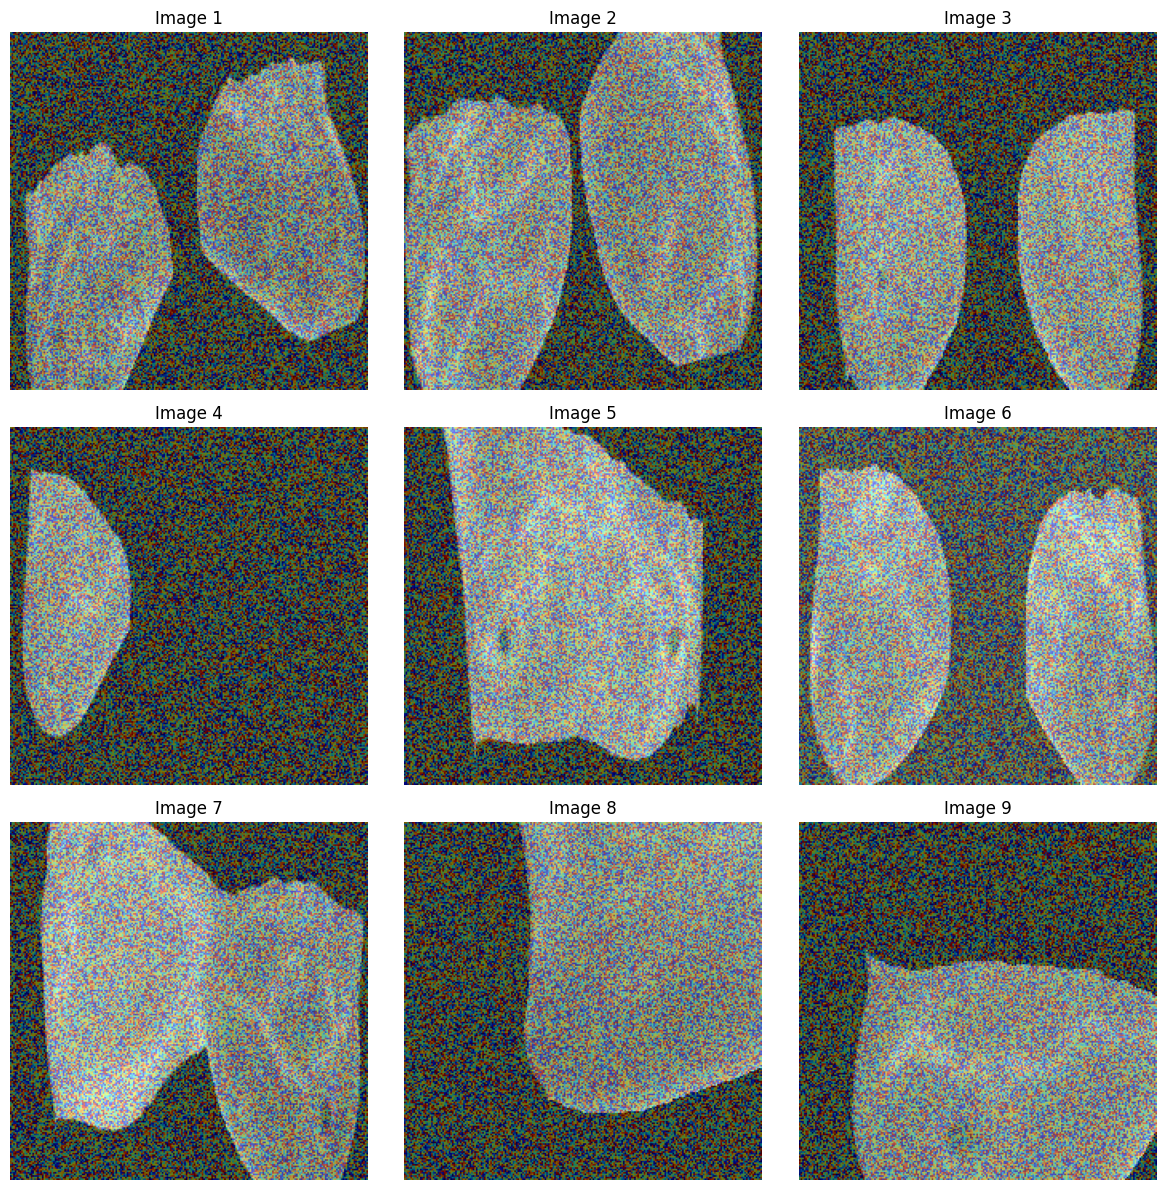

In [22]:
# Define all_images by listing image files in the final training directory
import os
import glob

all_images = glob.glob(os.path.join(final_train_dir, '*', '*.jpg'))

# Define a placeholder transform (replace with your actual transform)
# For visualization, you might not need the full training transform,
# but a simple resize and ToTensor might be sufficient depending on your needs.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ----- Plot grid setup -----
n_images = min(9, len(all_images))  # show up to 9 images
fig, axes = plt.subplots(3,3, figsize=(12,12))

for i in range(n_images):
    img = Image.open(all_images[i]).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # ----- Attention/GradCAM placeholder -----
    # Replace with your real attention map computation
    attn_map = np.random.rand(224,224)  # example random map

    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.imshow(attn_map, cmap='jet', alpha=0.5)
    ax.axis('off')
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [23]:
!pip install git+https://github.com/KindXiaoming/pykan.git --quiet

  Preparing metadata (setup.py) ... done


In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import timm
from kan import KAN
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [25]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
#  Load your existing data (from your last code)
# Assuming you already have these from your previous code
# train_loader, val_loader, test_loader, dataset.classes

#  Create feature extractor
# Load ViT model but remove the classification head (num_classes=0 gives us features)
feature_extractor = timm.create_model('vit_base_patch16_224',
                                     pretrained=True,
                                     num_classes=0).to(device)
feature_extractor.eval()  # Set to evaluation mode

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [27]:
#  Extract features from all datasets ---
def extract_features(dataloader, model):
    """
    Extract features from ViT for all images in dataloader
    Returns: features tensor, labels tensor
    """
    all_features = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = model(images)  # Shape: [batch_size, 768] for ViT-Base
            all_features.append(features.cpu())
            all_labels.append(labels)
    return torch.cat(all_features), torch.cat(all_labels)

print("Extracting training features...")
train_features, train_labels = extract_features(train_loader, feature_extractor)
print("Extracting validation features...")
val_features, val_labels = extract_features(val_loader, feature_extractor)
print("Extracting test features...")
test_features, test_labels = extract_features(test_loader, feature_extractor)

print(f"Training features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")

Extracting training features...
Extracting validation features...
Extracting test features...
Training features shape: torch.Size([3919, 768])
Validation features shape: torch.Size([840, 768])
Test features shape: torch.Size([841, 768])


In [28]:
# Create new DataLoaders for features ---
# This makes training much faster since we don't process images through ViT each time
train_dataset_feat = TensorDataset(train_features, train_labels)
val_dataset_feat = TensorDataset(val_features, val_labels)
test_dataset_feat = TensorDataset(test_features, test_labels)

train_loader_feat = DataLoader(train_dataset_feat, batch_size=32, shuffle=True)
val_loader_feat = DataLoader(val_dataset_feat, batch_size=32, shuffle=False)
test_loader_feat = DataLoader(test_dataset_feat, batch_size=32, shuffle=False)

In [ ]:
# Define KAN model
# KAN architecture: [768 (ViT features input), 32 (hidden), 2 (output: Benign, Malignant)]
kan_model = KAN(width=[768, 32, 2], grid=3, k=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(kan_model.parameters(), lr=1e-3)  # Optimizer only for KAN 

checkpoint directory created: ./model
saving model version 0.0


In [34]:
#Training Loop
num_epochs = 5
train_losses = []
val_accuracies = []

print("Starting KAN training (optimized version)...")
for epoch in range(num_epochs):
    # Training phase
    kan_model.train()
    running_loss = 0.0
    batch_count = 0

    for features, labels in train_loader_feat:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = kan_model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * features.size(0)
        batch_count += 1

        # Print progress every 10 batches
        if batch_count % 10 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_count}, Current Loss: {loss.item():.4f}')

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset_feat)
    train_losses.append(epoch_loss)

    # Validation phase at the end of each epoch
    kan_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in val_loader_feat:
            features, labels = features.to(device), labels.to(device)
            outputs = kan_model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_acc = 100 * correct / total
    val_accuracies.append(epoch_val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_val_acc:.2f}%')
    print('-' * 50)

print('KAN training completed!')

Starting KAN training (optimized version)...
Epoch 1, Batch 10, Current Loss: 0.5488
Epoch 1, Batch 20, Current Loss: 0.4674
Epoch 1, Batch 30, Current Loss: 0.5018
Epoch [1/5], Loss: 0.5354, Val Accuracy: 81.31%
--------------------------------------------------
Epoch 2, Batch 10, Current Loss: 0.3863
Epoch 2, Batch 20, Current Loss: 0.4269
Epoch 2, Batch 30, Current Loss: 0.2844
Epoch [2/5], Loss: 0.3702, Val Accuracy: 83.69%
--------------------------------------------------
Epoch 3, Batch 10, Current Loss: 0.2977
Epoch 3, Batch 20, Current Loss: 0.2814
Epoch 3, Batch 30, Current Loss: 0.3195
Epoch [3/5], Loss: 0.2876, Val Accuracy: 88.10%
--------------------------------------------------
Epoch 4, Batch 10, Current Loss: 0.2381
Epoch 4, Batch 20, Current Loss: 0.2470
Epoch 4, Batch 30, Current Loss: 0.1997
Epoch [4/5], Loss: 0.2270, Val Accuracy: 89.88%
--------------------------------------------------
Epoch 5, Batch 10, Current Loss: 0.1956
Epoch 5, Batch 20, Current Loss: 0.1831

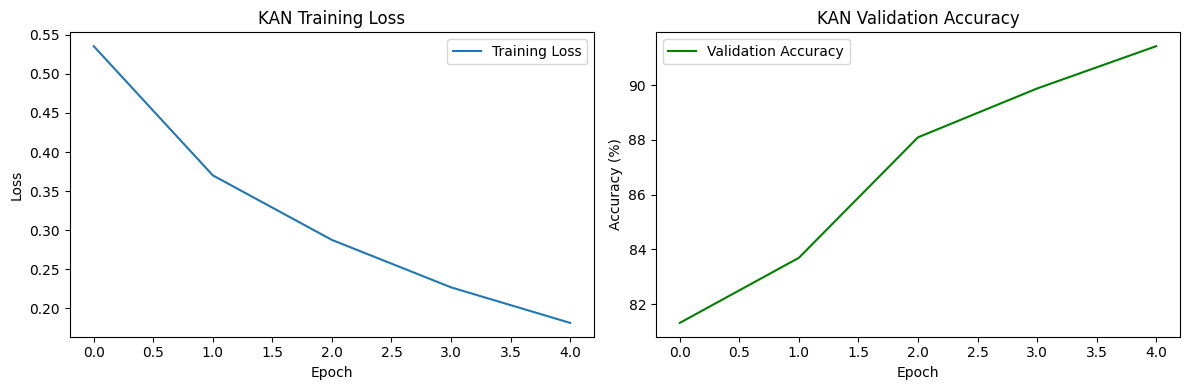

In [35]:
#  Plot training progress ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('KAN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('KAN Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
#  Final evaluation on test set ---
kan_model.eval()
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for features, labels in test_loader_feat:
        features, labels = features.to(device), labels.to(device)
        outputs = kan_model(features)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'✅ Final Test Accuracy (ViT + KAN): {test_accuracy:.2f}%')

✅ Final Test Accuracy (ViT + KAN): 93.10%


In [37]:
#  Detailed classification report ---
print("\n📊 Classification Report:")
print(classification_report(all_test_labels, all_test_preds,
                           target_names=['Benign', 'Malignant']))

print("📊 Confusion Matrix:")
print(confusion_matrix(all_test_labels, all_test_preds))


📊 Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.94      0.93       411
   Malignant       0.94      0.92      0.93       430

    accuracy                           0.93       841
   macro avg       0.93      0.93      0.93       841
weighted avg       0.93      0.93      0.93       841

📊 Confusion Matrix:
[[388  23]
 [ 35 395]]


In [38]:
# Try to extract symbolic formula (The main advantage of KAN!) ---
print("\n🔍 Attempting to extract KAN's symbolic formula...")
try:
    # Take a sample feature vector to help with symbolic regression
    sample_features = train_features[:1].to(device)  # Shape: [1, 768]
    formula = kan_model.symbolic_formula(sample_features)
    print("Symbolic formula suggested by KAN:")
    print(formula)
except Exception as e:
    print(f"⚠️ Could not extract a simple symbolic formula: {e}")
    print("This is normal if the relationship is too complex. Try increasing grid size or k.")


🔍 Attempting to extract KAN's symbolic formula...
⚠️ Could not extract a simple symbolic formula: iteration over a 0-d tensor
This is normal if the relationship is too complex. Try increasing grid size or k.


In [39]:
# Save the trained KAN model ---
torch.save(kan_model.state_dict(), 'vit_kan_breast_cancer.pth')
print("✅ KAN model saved successfully!")

✅ KAN model saved successfully!


In [40]:
# Compare with your original ViT accuracy
# Add your original ViT test accuracy here for comparison
original_vit_accuracy = 83.50  # Replace with your actual ViT accuracy
print(f"\n📈 Model Comparison:")
print(f"Original ViT Test Accuracy: {original_vit_accuracy:.2f}%")
print(f"ViT + KAN Test Accuracy: {test_accuracy:.2f}%")
print(f"Difference: {test_accuracy - original_vit_accuracy:+.2f}%")


📈 Model Comparison:
Original ViT Test Accuracy: 83.50%
ViT + KAN Test Accuracy: 93.10%
Difference: +9.60%
